In [65]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk.stem as stemmer
np.random.seed(2018)
import pandas as pd
import numpy as np
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords

In [66]:
df = pd.read_csv('SEC_Rule_making.csv', error_bad_lines=False)
df = df.drop("Author", axis = 1)
df['Title'].fillna('', inplace=True)

df['text_processed'] = df['Title'].apply(lambda x: re.sub('[,\.!?]', '', x).lower())

df.head()

<ipython-input-66-fe5d6e3029e4>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('SEC_Rule_making.csv', error_bad_lines=False)


,Title,URL,Body,Resource URL,text_processed
0,Volume-Based Exchange Transaction Pricing for ...,https://sec.gov/rules/2023/10/feetiers#34-98766,The Securities and Exchange Commission (“Commi...,https://sec.gov/files/rules/proposed/2023/34-9...,volume-based exchange transaction pricing for ...
1,Short Position and Short Activity Reporting by...,https://sec.gov/rules/2022/02/notice-text-prop...,The Securities and Exchange Commission (“Commi...,https://sec.gov/files/rules/proposed/2022/33-1...,short position and short activity reporting by...
2,Reporting of Securities Loans,https://sec.gov/rules/2021/11/reporting-securi...,The Securities and Exchange Commission (“SEC” ...,https://sec.gov/files/rules/proposed/2022/33-1...,reporting of securities loans
3,Modernization of Beneficial Ownership Reporting,https://sec.gov/rules/2022/02/modernization-be...,The Securities and Exchange Commission (“Commi...,https://sec.gov/files/rules/proposed/2023/33-1...,modernization of beneficial ownership reporting
4,Registration for Index-Linked Annuities; Amend...,https://sec.gov/rules/2023/09/rila#33-11250,The Commission is proposing to amend the offer...,https://sec.gov/files/rules/proposed/2023/33-1...,registration for index-linked annuities; amend...


In [67]:
df['text_processed'] = \
df['Title'].map(lambda x: re.sub('[,\.!?]', '', x))
df['text_processed'] = \
df['Title'].map(lambda x: x.lower())

In [68]:
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [69]:
import nltk
nltk.download('wordnet')
processed_docs = df['text_processed'].map(preprocess)
processed_docs[0:10]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [volum, base, exchang, transact, price, stock]
1    [short, posit, short, activ, report, institut,...
2                                [report, secur, loan]
3                [modern, benefici, ownership, report]
4    [registr, index, link, annuiti, amend, form, i...
5                            [commiss, privaci, regul]
6                              [invest, compani, name]
7                 [adopt, updat, edgar, filer, manual]
8               [edgar, filer, access, account, manag]
9                 [safeguard, advisori, client, asset]
Name: text_processed, dtype: object

In [70]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 base
1 exchang
2 price
3 stock
4 transact
5 volum
6 activ
7 institut
8 invest
9 manag
10 posit


In [71]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [72]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[50]

[(6, 1), (22, 1)]

In [74]:
bow_doc_4310 = bow_corpus[50]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0],
                                               dictionary[bow_doc_4310[i][0]],
bow_doc_4310[i][1]))

Word 6 ("modern") appears 1 time.
Word 22 ("disclosur") appears 1 time.


In [75]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.685362281070841), (1, 0.7282022683879621)]


In [76]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [125]:


topics_string = []
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    topics_string.append(topic)


Topic: 0 
Words: 0.228*"rule" + 0.167*"invest" + 0.160*"manag" + 0.117*"report" + 0.073*"compani" + 0.061*"exempt" + 0.044*"secur" + 0.024*"advis" + 0.024*"base" + 0.024*"swap"
Topic: 1 
Words: 0.441*"secur" + 0.121*"exempt" + 0.116*"certain" + 0.066*"disclosur" + 0.035*"exchang" + 0.024*"modern" + 0.020*"trade" + 0.016*"commiss" + 0.015*"base" + 0.015*"swap"
Topic: 2 
Words: 0.185*"filer" + 0.175*"edgar" + 0.169*"updat" + 0.154*"manual" + 0.154*"adopt" + 0.025*"form" + 0.021*"fund" + 0.021*"regul" + 0.018*"requir" + 0.015*"amend"
Topic: 3 
Words: 0.248*"disclosur" + 0.128*"secur" + 0.121*"swap" + 0.121*"base" + 0.078*"exempt" + 0.069*"updat" + 0.044*"dealer" + 0.039*"compani" + 0.030*"modern" + 0.025*"rule"
Topic: 4 
Words: 0.203*"amend" + 0.161*"regul" + 0.135*"form" + 0.093*"inform" + 0.089*"rule" + 0.070*"commiss" + 0.042*"secur" + 0.029*"disclosur" + 0.022*"manag" + 0.021*"advis"
Topic: 5 
Words: 0.199*"secur" + 0.144*"base" + 0.135*"swap" + 0.108*"dealer" + 0.076*"requir" + 0.059

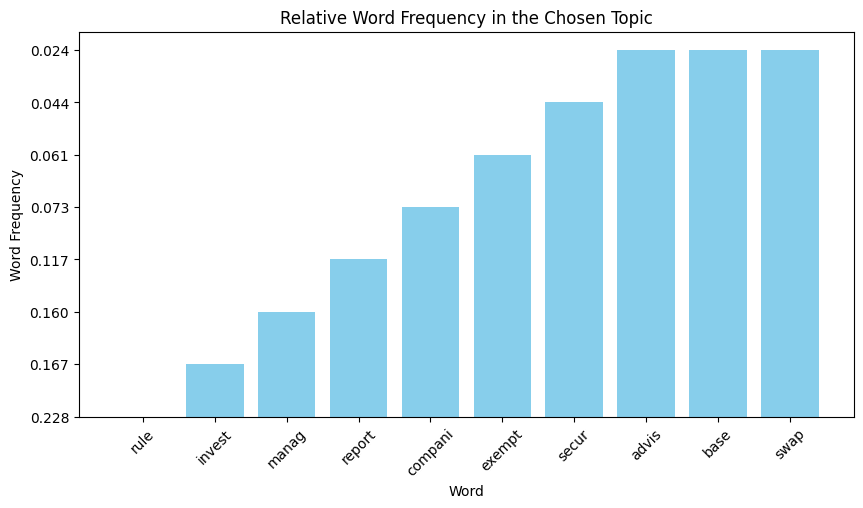

(['rule', 'invest', 'manag', 'report', 'compani', 'exempt', 'secur', 'advis', 'base', 'swap'], ['0.228', '0.167', '0.160', '0.117', '0.073', '0.061', '0.044', '0.024', '0.024', '0.024'])


In [143]:

def disp_graph(freq_array, word_array):
  plt.figure(figsize=(10, 5))
  plt.bar(freq_array, word_array, color='skyblue')
  plt.xlabel('Word')
  plt.ylabel('Word Frequency')
  plt.title('Relative Word Frequency in the Chosen Topic')
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.show()

def disp_heatmap(freq_array, word_array):
    plt.figure(figsize=(10, 5))

    # Create a 2D grid from the provided data
    freq_array = np.array(freq_array, dtype=float)
    word_array = np.array(word_array, dtype=float)

    # Plot the heatmap
    plt.imshow([freq_array], cmap='YlGnBu', aspect='auto', extent=[0, len(word_array), 0, 1])

    # Customize the axes and title
    plt.xlabel('Word')
    plt.ylabel('Word Frequency')
    plt.title('Relative Word Frequency in the Chosen Topic')
    plt.xticks(np.arange(len(word_array)), word_array, rotation=45)

    # Show the color bar
    plt.colorbar()

    plt.show()

def two_arr(topic):
  topic = topic.split(" + ")
  topic = "".join(topic)
  topic= topic.split("*")
  topic = "".join(topic)
  topic = topic.split('"')
  count = 0
  freq_array = []
  word_array = []
  for word in topic:
    if (count%2==0):
      word_array.append(topic[count])
    else:
      freq_array.append(topic[count])
    count += 1

  min_length = 0
  if (len(freq_array) > len(word_array)):
    min_length = len(word_array)
  else:
    min_length = len(freq_array)

  disp_graph(freq_array[:min_length],word_array[:min_length])
  return (freq_array[:min_length], word_array[:min_length])

print(two_arr(topics_string[0]))


<h1> Topic Selection <br>

<p> The bar graph represents which topic out of the 10 topics is most predominant in a particular document.

[(0, 0.77498364), (1, 0.025000192), (2, 0.025000175), (3, 0.025000025), (4, 0.025000945), (5, 0.025001822), (6, 0.025000934), (7, 0.025001673), (8, 0.025006264), (9, 0.025004327)]


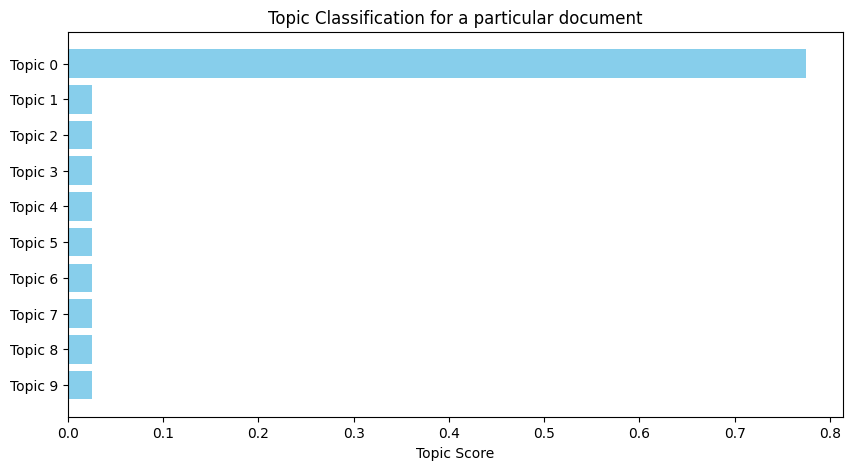

In [89]:
document_bow = dictionary.doc2bow(processed_docs[1])  # Replace with the document of interest
topic_scores = lda_model.get_document_topics(document_bow)
print(list(topic_scores))

import matplotlib.pyplot as plt

# Topic scores for the document (replace with actual scores)
topic_scores_ = []
for query in list(topic_scores):
  topic_scores_.append(query[1])

# Topic labels
topic_labels = ["Topic 0", "Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7", "Topic 8", "Topic 9"]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.barh(topic_labels, topic_scores_, color='skyblue')
plt.xlabel('Topic Score')
plt.title('Topic Classification for a particular document')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()


In [ ]:
#